## Data import and analysis

In [22]:
import pandas as pd

game_path = "./games.csv"
users_path = "./users.csv"
recommendations_path =  "./recommendations.csv"
games_metadata_path = "./games_metadata.json"

games = pd.read_csv(game_path)
users = pd.read_csv(users_path)
recommendations = pd.read_csv(recommendations_path)


In [23]:
import json

games_metadata = []
with open(games_metadata_path, 'r', encoding='utf-8') as f:
    for line in f:
      games_metadata.append(json.loads(line))

games_metadata_df = pd.DataFrame(games_metadata)

In [44]:
games.head()

app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount  steam_deck  
0       0.0        True  
1       0.0        True  
2       0.0        True  
3       0.0        True  
4       0.0        True

In [45]:
users.head()

user_id  products  reviews
0   7360263       359        0
1  14020781       156        1
2   8762579       329        4
3   4820647       176        4
4   5167327        98        2

In [46]:
recommendations.head()

app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12            True   36.3    51580   
1   304390        4      0  2017-02-17           False   11.5     2586   
2  1085660        2      0  2019-11-17            True  336.5   253880   
3   703080        0      0  2022-09-23            True   27.4   259432   
4   526870        0      0  2021-01-10            True    7.9    23869   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4

In [47]:
games_metadata_df.head()

app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                                      
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...

## Preprocessing

In [24]:
# anomalia, win == false to zazwyczaj soundtracki
an1 = games.loc[games["win"] == False]
an1_list = []
for row in an1.iterrows():
  an1_list.append(row)
games_no_an1 = games.drop(an1.index)
games_metadata_df_no_an1 = games_metadata_df.drop(an1.index)
an1_app_ids = an1["app_id"].unique()
recommendations_no_an1 = recommendations[~recommendations["app_id"].isin(an1_app_ids)]
recommendations_no_an1.reset_index(drop=True, inplace=True)

In [49]:
recommendations_no_an1

app_id  helpful  funny        date  is_recommended  hours  \
0          975370        0      0  2022-12-12            True   36.3   
1          304390        4      0  2017-02-17           False   11.5   
2         1085660        2      0  2019-11-17            True  336.5   
3          703080        0      0  2022-09-23            True   27.4   
4          526870        0      0  2021-01-10            True    7.9   
...           ...      ...    ...         ...             ...    ...   
41136304   633230        0      0  2021-02-15            True   41.0   
41136305   758870        8      0  2019-07-18           False    8.0   
41136306   696170        3     10  2018-03-26           False    2.0   
41136307   696170        0      0  2018-06-11            True    4.0   
41136308  1089980        2      0  2020-09-16            True   14.0   

           user_id  review_id  
0            51580          0  
1             2586          1  
2           253880          2  
3           259432          3  
4            23869          4  
...            ...        ...  
41136304   1606890   41154789  
41136305   1786254   41154790  
41136306   6370324   41154791  
41136307   1044289   41154792  
41136308  13971935   41154793  

[41136309 rows x 8 columns]

In [50]:
recommendations.shape

(41154794, 8)

In [25]:
positive = recommendations_no_an1.loc[recommendations_no_an1["is_recommended"] == True]
negative = recommendations_no_an1.loc[recommendations_no_an1["is_recommended"] == False]

In [26]:
print(positive.shape)
print(negative.shape)

(35286525, 8)
(5849784, 8)


Since only useful information for each graph for later stages is userID and appID, every other column could be dropped.

In [27]:
positive = positive.drop(['helpful', 'funny','date','is_recommended','hours','review_id'], axis=1)
negative = negative.drop(['helpful', 'funny','date','is_recommended','hours','review_id'], axis=1)
print(positive.shape)
print(negative.shape)

(35286525, 2)
(5849784, 2)


First save positives and negatives to files so they could be reused if program collapses and read by chunks to stabilize ram usage

In [54]:
positive.to_csv("positive.csv", index=False)
negative.to_csv("negative.csv", index=False)

Since we are supplied with 35 million reviews and around 8 million of them are done by users with only one review on their account it won't give us much useful information in here. That's why we could drop such recommendations and still have relatively good random-walk performance

In [48]:
import pandas as pd

users_path = "./users.csv"
users = pd.read_csv(users_path)

users_more_than_2_reviews = users[users["reviews"] > 30]
print(users_more_than_2_reviews.shape)

(95339, 3)


In [49]:
positive_shrank2 = positive[positive["user_id"].isin(users_more_than_2_reviews["user_id"])]


In [50]:
negative_csv = pd.read_csv("negative.csv")
negative_shrank2 = negative_csv[negative_csv["user_id"].isin(users_more_than_2_reviews["user_id"])]
negative_shrank2.to_csv("negative_shrank2.csv", index=False)

negative_shrank2.shape

(1048819, 2)

In [51]:
positive_shrank2.to_csv("positive_shrank2.csv", index=False)
positive_shrank2.shape

(4589066, 2)

## Naive implementation - Random Walk

First proposition is to construct algorithm based on randomwalk strategy. For each user choose random recommendation (edge) coming out of him, leading to one game. We consider two seperate graphs, one for positive recommendations only and one for negative ones.

In [46]:
import random
import pandas as pd
import json
import csv
from collections import defaultdict
import gc

def random_walk(edges_file, n, d, chunk_size=10**6, output_file="res.csv", users_per_save=1000):
    # Graph representation (bidirectional mapping)
    user_to_apps = defaultdict(list)
    app_to_users = defaultdict(list)

    # Read edges file in chunks
    reader = pd.read_csv(edges_file, chunksize=chunk_size, names=["app_id", "user_id"])

    for chunk in reader:
        # Update the graph with current chunk
        for app_id, user_id in zip(chunk["app_id"], chunk["user_id"]):
            user_to_apps[str(user_id)].append(str(app_id))
            app_to_users[str(app_id)].append(str(user_id))

    # Perform random walks
    batch_results = [("user_id", "app_counts")]
    i = 0
    num_of_batches = 0
    max_batches = len(user_to_apps)//users_per_save + 1
    for user in user_to_apps.keys():
        i += 1
        user_result = defaultdict(int)
        if user == 'user_id':
            continue
        for _ in range(n):
            # if user == '5924067':
        #     print("found")
            visited_apps = perform_random_walk(user, user_to_apps, app_to_users, d)
            for app, num in visited_apps.items():
                user_result[app] += num

        batch_results.append((user, json.dumps(user_result)))  # JSON-encoded app counts


        if (i >= users_per_save):
            num_of_batches += 1
            i = 0
            print(f"Progress save {num_of_batches} batch of {max_batches}")
            append_progress(batch_results, output_file)
            batch_results = []
            gc.collect()


    if batch_results:
        append_progress(batch_results, output_file)
        print("FINAL batch appended. File ready")
    user_to_apps.clear()
    app_to_users.clear()
    gc.collect()

def append_progress(results, output_file):
    with open(output_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results)


def perform_random_walk(start_user, user_to_apps, app_to_users, max_depth):
    visited_apps = dict()
    current_node = start_user
    depth = 0

    while depth < max_depth:
        # depth += 1

        # Decide the next step based on the current node type
        # if current_node in user_to_apps:  # Current node is a user
        #     neighbors = user_to_apps[current_node]
        # elif current_node in app_to_users:  # Current node is an app
        #     neighbors = app_to_users[current_node]
        # else:
        #     break  # Dead end

        if depth % 2 == 0 and current_node in user_to_apps:
            neighbors = user_to_apps[current_node]
        elif depth % 2 == 1 and current_node in app_to_users:
            neighbors = app_to_users[current_node]
        else:
            break


        # if not neighbors:
        #     break  # No neighbors, terminate walk

        # Randomly pick the next node
        next_node = random.choice(neighbors)

        depth += 1

        # If we visit an app, record it
        if depth % 2 == 1 and next_node not in user_to_apps[start_user]:
            if next_node in visited_apps:
                visited_apps[next_node] += 1
            else:
                visited_apps[next_node] = 1

        # Move to the next node
        current_node = next_node

    return visited_apps

# edges_file = "positive_shrank2.csv"  # Replace with your file path
# n = 50  # Number of random walks per user
# d = 5  # Maximum depth of each walk
# output_file = "positive_res6.csv"
# users_per_save = 100000


# random_walk(edges_file, n, d, output_file=output_file, users_per_save=users_per_save)

for presentation purpuses n = 20, d = 7 about 20 mins

for science n = 100, d = 7 about 42 mins positives, 15 mins negatives

In [3]:
import pandas as pd
import json

# Load the positive and negative results
positive_res = pd.read_csv("positive_res5.csv")
negative_res = pd.read_csv("negative_res5.csv")

# Convert JSON strings to dictionaries
positive_res["app_counts"] = positive_res["app_counts"].apply(json.loads)
negative_res["app_counts"] = negative_res["app_counts"].apply(json.loads)

def hybrid_recommendation(user_id, positive_res, negative_res, top_n=10):

    # Get the positive and negative app counts for the user
    positive_apps = positive_res.loc[positive_res["user_id"] == user_id, "app_counts"]
    # negative_apps = negative_res.loc[negative_res["user_id"] == user_id, "app_counts"]


    # if positive_apps.empty or negative_apps.empty:
    #     return []

    if positive_apps.empty:
        positive_apps = {}
    else:
        positive_apps = positive_apps.values[0]

    # if negative_apps.empty:
    #     negative_apps = {}
    # else:
    #     negative_apps = negative_apps.values[0]

    # Combine positive and negative app counts
    combined_apps = {}
    for app, count in positive_apps.items():
        combined_apps[app] = combined_apps.get(app, 0) + count
    # for app, count in negative_apps.items():
    #     combined_apps[app] = combined_apps.get(app, 0) - count

    # filtered_apps = {app: count for app, count in combined_apps.items() if }

    # Sort apps by combined score and return top N recommendations
    recommended_apps = sorted(combined_apps.items(), key=lambda x: x[1], reverse=True)
    recommended_apps = [(app, score) for app, score in recommended_apps if score > 1]

    # return [(app, score) for app, score in recommended_apps[:top_n]]
    return [(app, score) for app, score in recommended_apps]

# Example usage
user_id = 8762579  # Replace with the user ID you want to generate recommendations for
user_id2 = 1167857
top_n = 10  # Number of top recommendations to return
recommendations = hybrid_recommendation(user_id2, positive_res, negative_res, top_n)
print(f"Top {top_n} recommendations for user {user_id2}: {recommendations}")

C:\Users\MAX\AppData\Local\Temp\ipykernel_14340\4086172194.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  positive_res = pd.read_csv("positive_res5.csv")
C:\Users\MAX\AppData\Local\Temp\ipykernel_14340\4086172194.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  negative_res = pd.read_csv("negative_res5.csv")


Top 10 recommendations for user 1167857: [('238460', 3), ('431960', 3), ('239140', 3), ('444090', 3), ('466300', 2), ('49520', 2), ('711660', 2), ('477160', 2), ('234140', 2), ('648350', 2), ('3590', 2), ('550', 2), ('1250410', 2), ('814380', 2), ('42700', 2), ('553640', 2), ('1377550', 2), ('306130', 2), ('1086940', 2)]


In [4]:
user_id = 8762579  # Replace with the user ID you want to generate recommendations for
user_id2 = 1167857
top_n = 10  # Number of top recommendations to return

recommendations = hybrid_recommendation(user_id2, positive_res, negative_res, top_n)
print(f"Top {top_n} recommendations for user {user_id2}: {recommendations}")

recommendations2 = hybrid_recommendation(user_id, positive_res, negative_res, top_n)
print(f"Top {top_n} recommendations for user {user_id}: {recommendations2}")

Top 10 recommendations for user 1167857: [('238460', 3), ('431960', 3), ('239140', 3), ('444090', 3), ('466300', 2), ('49520', 2), ('711660', 2), ('477160', 2), ('234140', 2), ('648350', 2), ('3590', 2), ('550', 2), ('1250410', 2), ('814380', 2), ('42700', 2), ('553640', 2), ('1377550', 2), ('306130', 2), ('1086940', 2)]
Top 10 recommendations for user 8762579: [('787860', 5), ('261030', 2), ('227300', 2), ('233720', 2), ('555220', 2), ('270880', 2), ('1332010', 2), ('1274570', 2), ('1406990', 2), ('743450', 2), ('629760', 2), ('1238000', 2), ('40950', 2), ('414700', 2), ('250900', 2), ('1413480', 2)]


In [6]:

def get_game_title(app_id, games_df):

    game = games_df.loc[games_df['app_id'] == app_id]
    if not game.empty:
        return game.iloc[0]['title']
    else:
        return None

# Example usage
# app_id = 13500  # Replace with the app_id you want to find the title for
# game_title = get_game_title(app_id, games)
# print(f"The title of the game with app_id {app_id} is: {game_title}")


In [8]:
games = pd.read_csv("./games.csv")

for r in recommendations:
    print(f"id: {r}: {get_game_title(int(r[0]), games)}")
print(len(recommendations))

id: ('238460', 3): BattleBlock Theater®
id: ('431960', 3): Wallpaper Engine
id: ('239140', 3): Dying Light
id: ('444090', 3): Paladins®
id: ('466300', 2): Planescape: Torment: Enhanced Edition
id: ('49520', 2): Borderlands 2
id: ('711660', 2): CHUCHEL
id: ('477160', 2): Human: Fall Flat
id: ('234140', 2): Mad Max
id: ('648350', 2): Jurassic World Evolution
id: ('3590', 2): Plants vs. Zombies GOTY Edition
id: ('550', 2): Left 4 Dead 2
id: ('1250410', 2): Microsoft Flight Simulator 40th Anniversary Edition
id: ('814380', 2): Sekiro™: Shadows Die Twice - GOTY Edition
id: ('42700', 2): Call of Duty®: Black Ops
id: ('553640', 2): ICEY
id: ('1377550', 2): ~Be a maid in the Demon World~ The Secret Café of the Demon Angel Hero.
id: ('306130', 2): The Elder Scrolls® Online
id: ('1086940', 2): Baldur's Gate 3
19


In [9]:
for r in recommendations2:
    print(f"id: {r}: {get_game_title(int(r[0]), games)}")

id: ('787860', 5): Farming Simulator 19
id: ('261030', 2): The Walking Dead: Season Two
id: ('227300', 2): Euro Truck Simulator 2
id: ('233720', 2): Surgeon Simulator
id: ('555220', 2): Detention
id: ('270880', 2): American Truck Simulator
id: ('1332010', 2): Stray
id: ('1274570', 2): DEVOUR
id: ('1406990', 2): NEKOPARA Vol. 4
id: ('743450', 2): Monster Prom
id: ('629760', 2): MORDHAU
id: ('1238000', 2): Mass Effect™: Andromeda Deluxe Edition
id: ('40950', 2): Stronghold HD
id: ('414700', 2): Outlast 2
id: ('250900', 2): The Binding of Isaac: Rebirth
id: ('1413480', 2): Shin Megami Tensei III Nocturne HD Remaster


In [50]:
positive_shrank2 = pd.read_csv("positive_shrank2.csv")
negative_shrank2 = pd.read_csv("negative_shrank2.csv")

In [ ]:
def find_recommended_games(user_id, positive_df, negative_df):

    positive_games = positive_df[positive_df['user_id'] == user_id]['app_id'].tolist()
    negative_games = negative_df[negative_df['user_id'] == user_id]['app_id'].tolist()

    positive_games = [get_game_title(int(game), games) for game in positive_games]
    negative_games = [get_game_title(int(game), games) for game in negative_games]

    return {
        'positive': positive_games,
        'negative': negative_games
    }

# Example usage
user_id = 8762579  # Replace with the user ID you want to check
recommended_games = find_recommended_games(user_id, positive_shrank2, negative_shrank2)

print(f"Games recommended by user {user_id} in positive_shrank2: {recommended_games['positive']}")
print(f"Games recommended by user {user_id} in negative_shrank2: {recommended_games['negative']}")

Games recommended by user 8762579 in positive_shrank2: ['Days Gone', 'Grand Theft Auto V', 'Sniper Elite 5']
Games recommended by user 8762579 in negative_shrank2: ['Battlefield™ 2042']


In [78]:
user_id = 1167857  # Replace with the user ID you want to check
recommended_games = find_recommended_games(user_id, positive_shrank2, negative_shrank2)

print(f"Games recommended by user {user_id} in positive_shrank2: {recommended_games['positive']}")
print(f"Games recommended by user {user_id} in negative_shrank2: {recommended_games['negative']}")

Games recommended by user 1167857 in positive_shrank2: ['Just Cause™ 3', 'Dead Cells', 'Unheard - Voices of Crime']
Games recommended by user 1167857 in negative_shrank2: []


In [81]:
negative_shrank2.dtypes

app_id     int64
user_id    int64
dtype: object

## Target model - Cleora

We will use data from positive_shrank2.csv and negative_shrank2.csv to perform target algorithm on the same data as used in naive approach.

In [3]:
import pandas as pd

positive_shrank2 = pd.read_csv('positive_shrank2.csv')
negative_shrank2 = pd.read_csv('negative_shrank2.csv')



In [4]:
from pycleora import SparseMatrix
import numpy as np
import pandas as pd
import random

# positive_shrank2['user_id'] = 'u' + positive_shrank2['user_id'].astype(str)
# positive_shrank2['app_id'] = 'a' + positive_shrank2['app_id'].astype(str)

# positive_shrank2.rename(columns={"user_id": "source", "app_id": "target"}, inplace=True)

# user_games_positive = positive_shrank2.groupby('source')['target'].apply(list).values
# user_games_negative = negative_shrank2.groupby('user_id')['app_id'].apply(list).values

user_games_positive = positive_shrank2.groupby('user_id')['app_id'].apply(list).values

for i in range(len(user_games_positive)):
    for j in range(len(user_games_positive[i])):
        user_games_positive[i][j] = str(user_games_positive[i][j])

cleora_input = map(lambda x: ' '.join(map(str, x)), user_games_positive)
print(cleora_input)


In [5]:
for i in range(len(user_games_positive)):
    for j in range(len(user_games_positive[i])):
        user_games_positive[i][j] = str(user_games_positive[i][j])

In [6]:
mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::target')
print(mat.entity_ids)

['10180', '200710', '678950', '1091500', '307780', '391220', '241930', '47780', '462780', '360150', '269790', '247910', '249870', '13500', '238010', '261110', '582010', '1085660', '209000', '50130', '8140', '282530', '212630', '292030', '208650', '207750', '223220', '300540', '211400', '209120', '395170', '282070', '272470', '215510', '423950', '751690', '220260', '35720', '236390', '4000', '595520', '505460', '220200', '620', '1434950', '220', '420530', '784150', '55230', '346010', '259080', '774091', '1134710', '1507780', '8190', '251110', '754150', '73010', '39000', '1248130', '573090', '492720', '700600', '244850', '359320', '868360', '493340', '673610', '233450', '311310', '1250410', '787860', '228380', '1292910', '461430', '242920', '1062830', '503560', '362620', '365450', '248610', '620190', '3720', '871530', '591370', '1397920', '518790', '1201400', '333950', '57690', '306130', '271590', '377160', '47890', '200510', '261640', '204100', '232090', '433340', '203770', '4570', '254

In [7]:
embeddings = mat.initialize_deterministically(1024)

NUM_WALKS = 4

for i in range(NUM_WALKS):
    embeddings = mat.left_markov_propagate(embeddings)
    embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

game_embedding = dict()

for entity, embedding in zip(mat.entity_ids, embeddings):
    game_embedding[entity] = embedding
    print(entity, embedding)

10180 [-0.02495949 -0.03462588 -0.04314014 ...  0.04730972 -0.01733371
  0.02495383]
200710 [-0.02505535 -0.03484663 -0.04202568 ...  0.04657012 -0.01857877
  0.02405643]
678950 [-0.02557969 -0.03503225 -0.04203012 ...  0.04739395 -0.01842669
  0.02462237]
1091500 [-0.02542473 -0.03517995 -0.04192344 ...  0.04740123 -0.01853492
  0.02441338]
307780 [-0.02519938 -0.03468962 -0.04256874 ...  0.04721767 -0.01783997
  0.02469648]
391220 [-0.02522724 -0.03467184 -0.04184432 ...  0.04697978 -0.01854544
  0.02430409]
241930 [-0.02509504 -0.03479791 -0.04214543 ...  0.04678139 -0.01837076
  0.02426134]
47780 [-0.02513622 -0.03468742 -0.04241705 ...  0.0468878  -0.0181323
  0.02454302]
462780 [-0.02519223 -0.03463449 -0.04192353 ...  0.04665533 -0.01853701
  0.02422641]
360150 [-0.02484839 -0.03454128 -0.04285709 ...  0.04673634 -0.01764072
  0.02454567]
269790 [-0.02523536 -0.03449297 -0.04204008 ...  0.0468179  -0.01841224
  0.02441148]
247910 [-0.02491723 -0.03466434 -0.04296923 ...  0.04697

In [16]:
from pycleora import SparseMatrix
import numpy as np
import pandas as pd
import random

def train_cleora(input, embedding_size=1024, num_walks=4):
    user_games_positive = input.groupby('user_id')['app_id'].apply(list).values

    for i in range(len(user_games_positive)):
        for j in range(len(user_games_positive[i])):
            user_games_positive[i][j] = str(user_games_positive[i][j])

    cleora_input = map(lambda x: ' '.join(map(str, x)), user_games_positive)
    for i in range(len(user_games_positive)):
        for j in range(len(user_games_positive[i])):
            user_games_positive[i][j] = str(user_games_positive[i][j])

    mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::target')

    embeddings = mat.initialize_deterministically(embedding_size)


    for i in range(num_walks):
        embeddings = mat.left_markov_propagate(embeddings)
        embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

    game_embedding = dict()

    for entity, embedding in zip(mat.entity_ids, embeddings):
        game_embedding[entity] = embedding

    return game_embedding



In [9]:
print(np.dot(embeddings[0], embeddings[1]))
print(np.dot(embeddings[0], embeddings[2]))
print(np.dot(embeddings[0], embeddings[3]))

print(np.dot(embeddings[1], embeddings[2]))
print(np.dot(embeddings[24234], embeddings[35343]))

print(len(embeddings))
print(np.dot(embeddings[0], embeddings[0]))


0.96917117
0.9739728
0.97358024
0.97956735
0.94977784
37244
1.0


#### Tests for 3 iterations and 4096 features

In [23]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(10000):
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, 10000):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0.14619623
0.99987566
0.9316763337359454


In [138]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(len(embeddings)):
    if i % 1000 == 0:
        print(i)
    for j in range(i + 1, len(embeddings)):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
-0.056952752
1.0000002
0.5575130600871142


#### Test for 4 steps and 4096 features

In [140]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(10000):
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, 10000):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
-0.011556799
0.99987054
0.9308325981426849


In [141]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(len(embeddings)):
    if i % 1000 == 0:
        print(i)
    for j in range(i + 1, len(embeddings)):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
-0.043294627
1.0000002
0.8834468319946317


#### Test for 5 steps and 4096 features

In [135]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(10000):
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, 10000):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0.015157038
0.9999829
0.9836907279060012


#### Test for 7 steps and 4096 features

In [131]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(10000):
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, 10000):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0.034985483
0.9999993
0.9981419510006917


In [133]:
min = 2
max = -2
sum = 0
counter = 0
for i in range(len(embeddings)):
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, len(embeddings)):
        counter += 1
        dot = np.dot(embeddings[i], embeddings[j])
        sum += dot
        if dot < min:
            min = dot
        if dot > max:
            max = dot

avg = sum / counter
print(min)
print(max)
print(avg)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

## Random Walk with comparig similarity based on Cleora embedding

In [24]:
import random
import pandas as pd
import json
import csv
from collections import defaultdict
import gc
import numpy as np

def random_walk_cleaora(edges_file, n, d, game_embedding, chunk_size=10**6, output_file="res.csv", users_per_save=1000):
    """
    Perform random walks on a graph from an edge list stored in a file.

    Args:
        edges_file (str): Path to the edges file (CSV format: app_id, user_id).
        n (int): Number of random walks per user.
        d (int): Maximum depth of each random walk.
        chunk_size (int): Number of rows to process at a time.

    Returns:
        defaultdict: Dictionary where keys are user IDs and values are defaultdicts
                     mapping app IDs to visit counts.
    """
    # Graph representation (bidirectional mapping)
    user_to_apps = defaultdict(list)
    app_to_users = defaultdict(list)

    # Read edges file in chunks
    reader = pd.read_csv(edges_file, chunksize=chunk_size, names=["app_id", "user_id"])
    # for i in reader:
    #     print(i)
    #     break


    for chunk in reader:
        # Update the graph with current chunk
        for app_id, user_id in zip(chunk["app_id"], chunk["user_id"]):
            user_to_apps[str(user_id)].append(str(app_id))
            app_to_users[str(app_id)].append(str(user_id))

    # print(user_to_apps['13774658'])
    # print(user_to_apps[13774658])

    # print(user_to_apps["6209537"])
    # print(user_to_apps[6209537])

    # Perform random walks
    batch_results = [("user_id", "app_counts")]
    i = 0
    num_of_batches = 0
    max_batches = len(user_to_apps)//users_per_save + 1
    for user in user_to_apps.keys():
        # if user == '5924067':
        #     print("found")
        i += 1
        user_result = defaultdict(float)
        # print(len(user_to_apps[user]))
        if user == 'user_id':
            continue
        for _ in range(n):
            # print(user_to_apps[user])

            visited_apps = perform_random_walk(user, game_embedding, user_to_apps, app_to_users, d)
            for app, score in visited_apps.items():
                user_result[app] = score

        # if user == '13774658' or user == 13774658:
        #     print(user_result)

        batch_results.append((user, json.dumps(user_result)))  # JSON-encoded app counts


        if (i >= users_per_save):
            num_of_batches += 1
            i = 0
            print(f"Progress save {num_of_batches} batch of {max_batches}")
            append_progress(batch_results, output_file)
            batch_results = []
            gc.collect()


    if batch_results:
        append_progress(batch_results, output_file)
        print("FINAL batch appended. File ready")
    user_to_apps.clear()
    app_to_users.clear()
    gc.collect()

def append_progress(results, output_file):
    """
    Append a batch of user-app counts to a file.

    Args:
        batch_results (list): List of dictionaries containing user results.
        output_file (str): File to append the progress.

    Returns:
        None
    """
    with open(output_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results)


def perform_random_walk(start_user, game_embedding, user_to_apps, app_to_users, max_depth):
    """
    Perform a single random walk starting from a user.

    Args:
        start_user (int): Starting user ID.
        user_to_apps (dict): Mapping from users to apps.
        app_to_users (dict): Mapping from apps to users.
        max_depth (int): Maximum depth of the random walk.

    Returns:
        set: Set of app IDs visited during the random walk.
    """
    visited_apps = dict()
    current_node = start_user
    depth = 0


    # if user == '5924067':
        #     print("found")

    while depth < max_depth:
        # depth += 1

        # Decide the next step based on the current node type
        # if current_node in user_to_apps:  # Current node is a user
        #     neighbors = user_to_apps[current_node]
        # elif current_node in app_to_users:  # Current node is an app
        #     neighbors = app_to_users[current_node]
        # else:
        #     break  # Dead end

        if depth % 2 == 0 and current_node in user_to_apps:
            neighbors = user_to_apps[current_node]
        elif depth % 2 == 1 and current_node in app_to_users:
            neighbors = app_to_users[current_node]
        else:
            break


        # if not neighbors:
        #     break  # No neighbors, terminate walk

        # Randomly pick the next node
        if not neighbors:
            break
        next_node = random.choice(neighbors)

        depth += 1

        # If we visit an app, record it
        if depth % 2 == 1 and next_node not in user_to_apps[start_user]:
            similarity = -2

            for game in user_to_apps[start_user]:
                dot_product = np.dot(game_embedding[str(game)], game_embedding[str(next_node)])
                pom = [dot_product, similarity]
                # print(dot_product, norm_user, norm_product)
                similarity = np.max(pom)
                # similarity = max(similarity, float(dot_product / norm_user * norm_product))

            visited_apps[next_node] = similarity
        # Move to the next node
        current_node = next_node

    return visited_apps

# edges_file = "positive_shrank2.csv"  # Replace with your file path
# n = 20  # Number of random walks per user
# d = 5   # Maximum depth of each walk
# output_file = "cleora_random_res3.csv"
# users_per_save = 1000


# random_walk(edges_file, n, d, output_file=output_file, users_per_save=users_per_save)

## Second level embedding

In [ ]:
import heapq

games_similarity = []
k = 50

for i in range(len(embeddings)):
    temp = []
    if i % 100 == 0:
        print(i)
    for j in range(i + 1, len(embeddings)):
        dot = np.dot(embeddings[i], embeddings[j])
        n1 = np.linalg.norm(embeddings[i])
        n2 = np.linalg.norm(embeddings[j])
        res = dot / (n1 * n2)

        if len(temp) < k:
            heapq.heappush(temp, (res, j))
        else:
            heapq.heappushpop(temp, (res, j))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [36]:
# from sklearn.metrics.pairwise import cosine_similarity

games_ids = mat.entity_ids
# games_similarity = cosine_similarity(embeddings)

#empirically chosen based on the average similarity between embeddings
similarity_treshold = 0.9

games_edges = []

for i in range(len(games_ids)):
    for j in range(i + 1, len(games_ids)):
        if games_similarity[i][j] > similarity_treshold:
            games_edges.append((games_ids[i], games_ids[j]))

games_edges_df = pd.DataFrame(games_edges, columns=["source", "target"])

user_games_df = positive_shrank2[["source", "target"]]

games_edges_df[type] = 'g-g'
user_games_df[type] = 'u-g'

combined_edges = pd.concat([games_edges_df, user_games_df], ignore_index=True)

combined_edges.to_csv("combined_edges.csv", index=False)

KeyboardInterrupt: 

In [ ]:
combined_edges

## Testing phase

Supposing we have the model saved in file with format of user_id - list of pairs (app_id, their likeliness of connection with the user) The queries in testing subset are in similar format, but only existing edges between user and app are included
Given loaded model with above format and test set divided into Queries and Real Answers evaluate different metrics for various K's (top K recommended edges):
- Recall@K (average for whole test set)
- MRR@K
- HR@K

In [77]:
# Since every metric is used in the same way
# For each Query get K most relevant edges and measure them with real edges
def measure_score(model, test_X, test_Y, K = 10, _recall=True, _mrr=True, _hr=True):
    total_mrr = 0
    total_hits = 0
    total_recall = 0
    analysed = 0
    results = {}

    for i in range(len(test_X)):
        Query = test_X[i]
        Answers = set(test_Y[i])
        # print(Query)
        # print(Answers)
        Predictions = model.loc[model["user_id"] == Query, "app_counts"]
        if Predictions.empty:
            # print("empty")
            continue
        Predictions = list(Predictions.values[0].items())
        # Predictions = model.get(Query) # Should return models predictions or None

        # There could be a problem with the division of the sets
        # user hypothetically may appear only in train/test leading to model or test set not measuring it properly
        # we could leave this cases out, or check it first and include in overall measurements
        if (Predictions is None):
            # print("none")
            continue
        else:
            analysed += 1
            Predictions.sort(key=lambda x: x[1], reverse=True)


        first_hit = K
        hits = 0
        for i in range(min(len(Predictions), K)):
            # print(Predictions[i], Answers)
            if (int(Predictions[i][0]) in Answers):
                # print("hit")
                if first_hit == K:
                    first_hit = i
                hits += 1
        if _recall:
            total_recall += hits/min(K,max(len(Answers), 1))
        if _mrr:
            total_mrr += 1 / (first_hit + 1)
        if _hr:
            if hits>0:
                total_hits += 1

    if _recall:
        results['recall'] = total_recall/analysed
    if _mrr:
        results['mrr'] = total_mrr/analysed
    if _hr:
        results['hr'] = total_hits/analysed

    return results

In [78]:
def make_test(input, test_X, test_Y, K=10, _fscore=True, _mrr=True, _hr=True):
    temp = pd.read_csv(input)
    temp["app_counts"] = temp["app_counts"].apply(json.loads)
    # model = temp.loc[temp["user_id"] == user_id, "app_counts"]
    return measure_score(temp, test_X, test_Y, K, _fscore, _mrr, _hr)

In [12]:
positive_shrank2 = pd.read_csv("positive_shrank2.csv")
train_set = positive_shrank2.sample(frac=0.8, random_state=42)

test_set = positive_shrank2.drop(train_set.index)

print(train_set.shape)
print(test_set.shape)


(3671253, 2)
(917813, 2)


In [79]:
train_set.to_csv("train_set.csv", index=False)

In [13]:
test_set_2 = test_set.groupby('user_id')['app_id'].apply(list).reset_index()
test_set.to_csv("test_set.csv", index=False)
test_set_2_x = test_set_2['user_id']
test_set_2_y = test_set_2['app_id']
print(test_set_2_x)


0             257
1             464
2             814
3            1072
4            1209
           ...   
94987    14305387
94988    14305396
94989    14305521
94990    14305792
94991    14305966
Name: user_id, Length: 94992, dtype: int64


In [80]:
test_set_X = test_set["user_id"].values
test_set_Y = test_set["app_id"].values

In [17]:
test_embedding_1024_4 = train_cleora(train_set, embedding_size=1024, num_walks=4)

test_embedding_1024_5 = train_cleora(train_set, embedding_size=1024, num_walks=5)

test_embedding_4096_4 = train_cleora(train_set, embedding_size=4096, num_walks=4)

test_embedding_4096_5 = train_cleora(train_set, embedding_size=4096, num_walks=5)

### Random walk model training

In [49]:
random_walk("train_set.csv", 20, 5, output_file="naive_random_20_5.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_31508\1918175811.py:16: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [50]:
random_walk("train_set.csv", 20, 7, output_file="naive_random_20_7.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_31508\1918175811.py:16: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [51]:
random_walk("train_set.csv", 50, 5, output_file="naive_random_50_5.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_31508\1918175811.py:16: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [52]:
random_walk("train_set.csv", 50, 7, output_file="naive_random_50_7.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_31508\1918175811.py:16: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [87]:
test_nr_20_5 = make_test("naive_random_20_5.csv", test_set_2_x, test_set_2_y)
print(test_nr_20_5)

{'recall': 0.010258014841107369, 'mrr': 0.10972441270262771, 'hr': 0.07367479075643522}


In [88]:
test_nr_20_7 = make_test("naive_random_20_7.csv", test_set_2_x, test_set_2_y)
print(test_nr_20_7)

{'recall': 0.009797787620602176, 'mrr': 0.11028956269479656, 'hr': 0.06990577459598885}


In [89]:
test_nr_50_5 = make_test("naive_random_50_5.csv", test_set_2_x, test_set_2_y)
print(test_nr_50_5)

{'recall': 0.012790411351499824, 'mrr': 0.11763917003391584, 'hr': 0.09003526872664105}


In [90]:
test_nr_50_7 = make_test("naive_random_50_7.csv", test_set_2_x, test_set_2_y)
print(test_nr_50_7)

{'recall': 0.014893679954478262, 'mrr': 0.11914282356894884, 'hr': 0.10453229457282728}


### Random walk with Cleora model training

In [72]:
random_walk_cleaora("train_set.csv", 20, 5, test_embedding_1024_4, output_file="cleora_1024_4_random_20_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [74]:
random_walk_cleaora("train_set.csv", 20, 5, test_embedding_4096_4, output_file="cleora_4096_4_random_20_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [73]:
random_walk_cleaora("train_set.csv", 20, 5, test_embedding_4096_5, output_file="cleora_4096_5_random_20_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [75]:
random_walk_cleaora("train_set.csv", 20, 5, test_embedding_1024_5, output_file="cleora_1024_5_random_20_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [82]:
test_cr_1024_4 = make_test("cleora_1024_4_random_20_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_1024_4)

{'recall': 0.02231729571335581, 'mrr': 0.1385489590103185, 'hr': 0.15117123756382586}


In [83]:
test_cr_1024_5 = make_test("cleora_1024_5_random_20_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_1024_5)

{'recall': 0.02175726994487628, 'mrr': 0.13599712637872613, 'hr': 0.14830762752013477}


In [84]:
test_cr_4096_4 = make_test("cleora_4096_4_random_20_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_4096_4)

{'recall': 0.022442068964938597, 'mrr': 0.13927802605143363, 'hr': 0.1525504026951624}


In [85]:
test_cr_4096_5 = make_test("cleora_4096_5_random_20_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_4096_5)

{'recall': 0.021757107011881823, 'mrr': 0.13653100500967796, 'hr': 0.14814970784860768}


In [95]:
random_walk_cleaora("train_set.csv", 50, 5, test_embedding_4096_5, output_file="cleora_4096_5_random_50_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [96]:
random_walk_cleaora("train_set.csv", 50, 5, test_embedding_4096_4, output_file="cleora_4096_4_random_50_5_2.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [99]:
test_cr_4096_5_50 = make_test("cleora_4096_5_random_50_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_4096_5_50)

{'recall': 0.02871993572919654, 'mrr': 0.14688985866328802, 'hr': 0.19018792440911722}


In [101]:
test_cr_4096_4_50 = make_test("cleora_4096_4_random_50_5_2.csv", test_set_2_x, test_set_2_y)
print(test_cr_4096_5_50)

{'recall': 0.02871993572919654, 'mrr': 0.14688985866328802, 'hr': 0.19018792440911722}


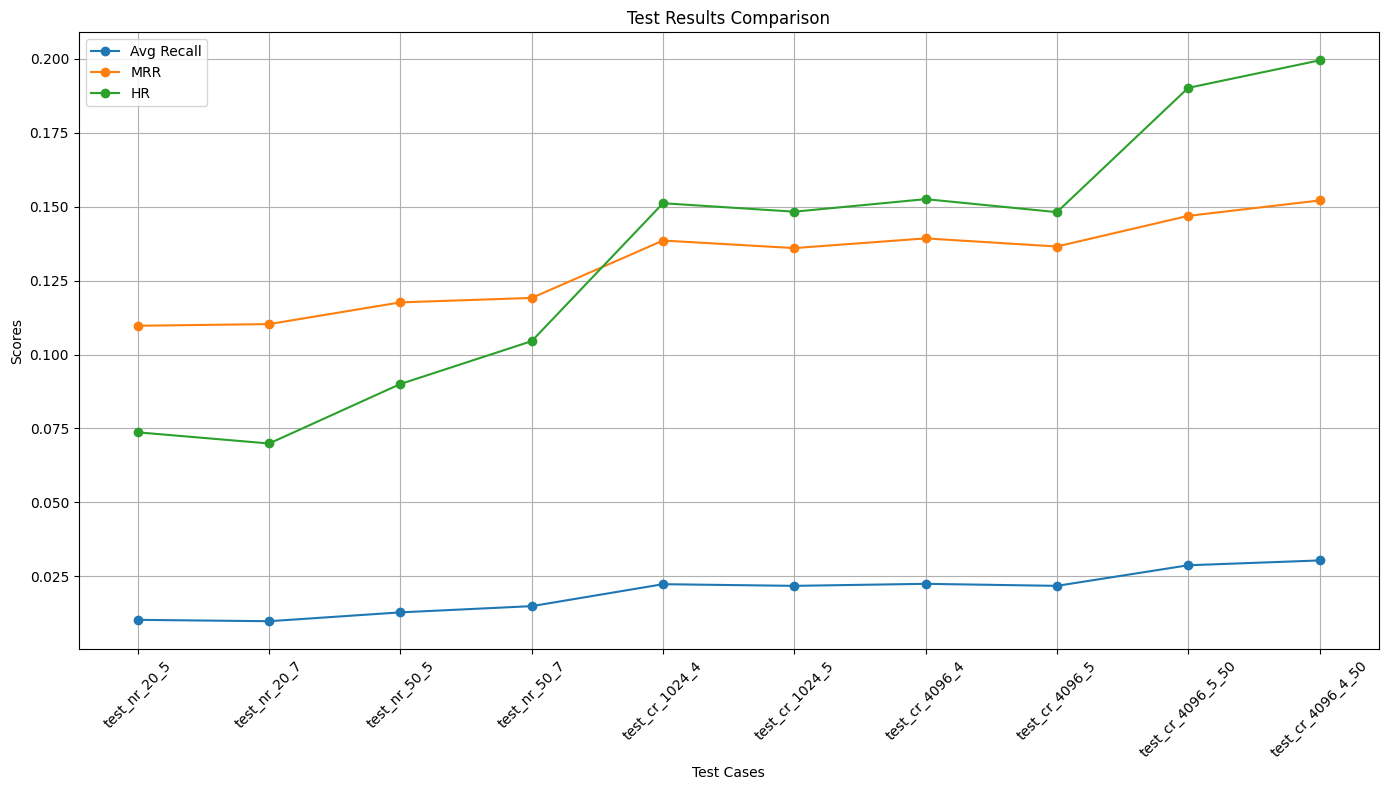

In [102]:
import matplotlib.pyplot as plt

# Test results
test_results = {
    "test_nr_20_5": test_nr_20_5,
    "test_nr_20_7": test_nr_20_7,
    "test_nr_50_5": test_nr_50_5,
    "test_nr_50_7": test_nr_50_7,
    "test_cr_1024_4": test_cr_1024_4,
    "test_cr_1024_5": test_cr_1024_5,
    "test_cr_4096_4": test_cr_4096_4,
    "test_cr_4096_5": test_cr_4096_5,
    "test_cr_4096_5_50": test_cr_4096_5_50,
    "test_cr_4096_4_50": test_cr_4096_4_50
}

# Extract metrics
recall = [result['recall'] for result in test_results.values()]
mrr = [result['mrr'] for result in test_results.values()]
hr = [result['hr'] for result in test_results.values()]
labels = list(test_results.keys())

# Plotting
x = range(len(labels))

plt.figure(figsize=(14, 8))

plt.plot(x, recall, label='Avg Recall', marker='o')
plt.plot(x, mrr, label='MRR', marker='o')
plt.plot(x, hr, label='HR', marker='o')

plt.xticks(x, labels, rotation=45)
plt.xlabel('Test Cases')
plt.ylabel('Scores')
plt.title('Test Results Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

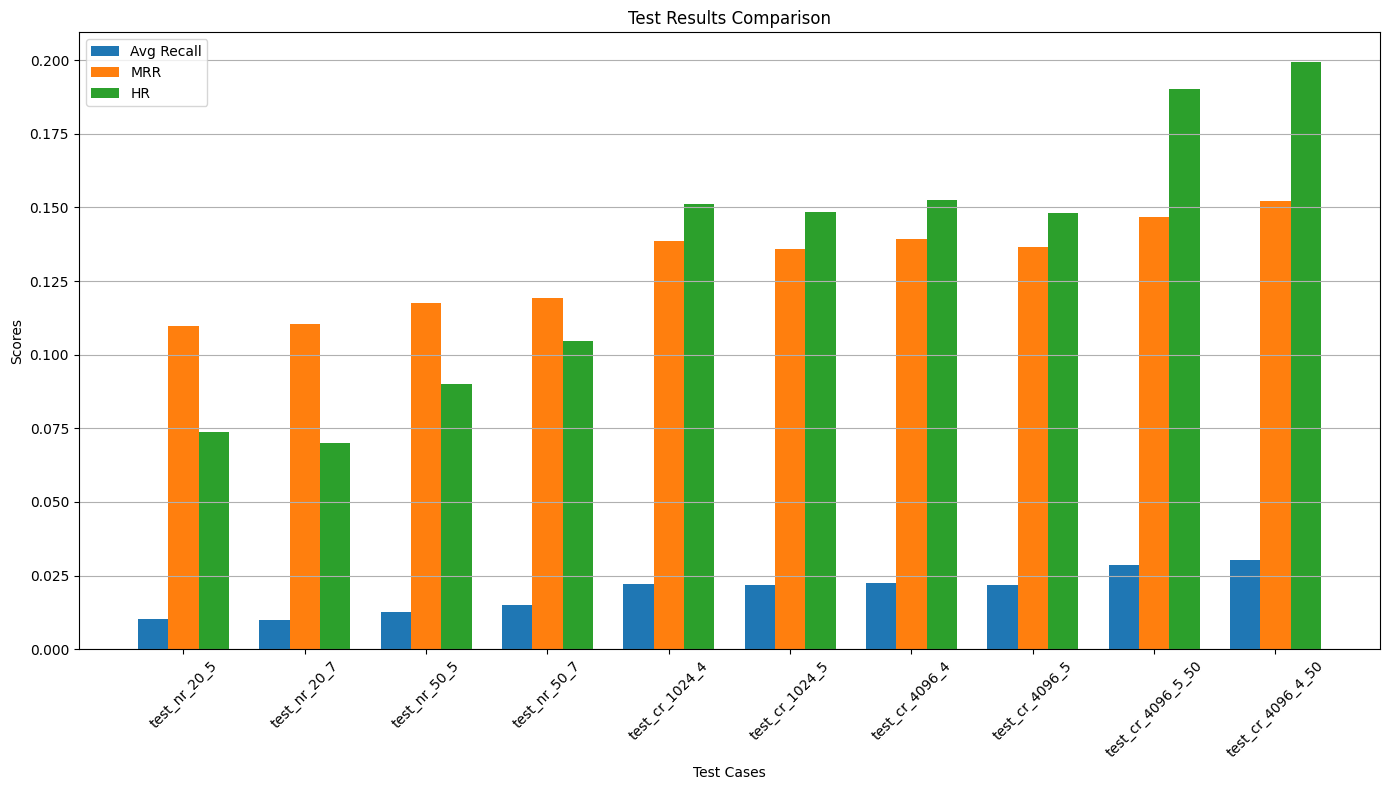

In [103]:
import matplotlib.pyplot as plt

# Test results
test_results = {
    "test_nr_20_5": test_nr_20_5,
    "test_nr_20_7": test_nr_20_7,
    "test_nr_50_5": test_nr_50_5,
    "test_nr_50_7": test_nr_50_7,
    "test_cr_1024_4": test_cr_1024_4,
    "test_cr_1024_5": test_cr_1024_5,
    "test_cr_4096_4": test_cr_4096_4,
    "test_cr_4096_5": test_cr_4096_5,
    "test_cr_4096_5_50": test_cr_4096_5_50,
    "test_cr_4096_4_50": test_cr_4096_4_50
}

# Extract metrics
recall = [result['recall'] for result in test_results.values()]
mrr = [result['mrr'] for result in test_results.values()]
hr = [result['hr'] for result in test_results.values()]
labels = list(test_results.keys())

# Plotting
x = range(len(labels))

plt.figure(figsize=(14, 8))

bar_width = 0.25
plt.bar(x, recall, width=bar_width, label='Avg Recall')
plt.bar([p + bar_width for p in x], mrr, width=bar_width, label='MRR')
plt.bar([p + bar_width * 2 for p in x], hr, width=bar_width, label='HR')

plt.xticks([p + bar_width for p in x], labels, rotation=45)
plt.xlabel('Test Cases')
plt.ylabel('Scores')
plt.title('Test Results Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

In [ ]:
times= [
    ("randomwalk(20, 5)", 48.4)
    ("randomwalk(20, 7)", 52.5)
    ("randomwalk(50, 5)", 61.1)
    ("randomwalk(50, 7)", 70)
    ("cleora(n = 20)", 8*60 + 10)
    ("cleora(4096, 5, n = 50)", 19*60 + 28)
]

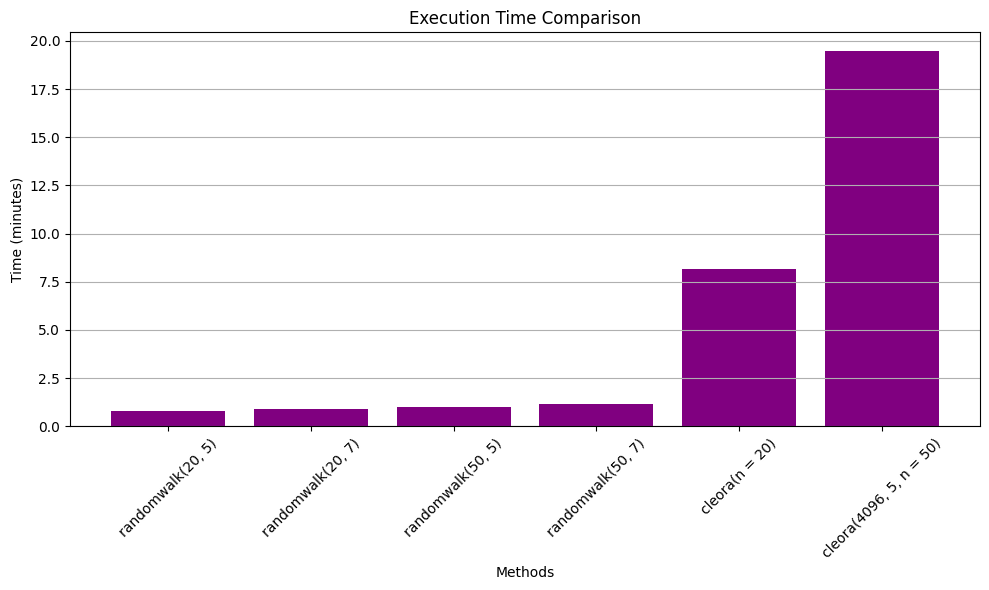

In [ ]:
import matplotlib.pyplot as plt

# Times data
times = [
    ("randomwalk(20, 5)", 48.4),
    ("randomwalk(20, 7)", 52.5),
    ("randomwalk(50, 5)", 61.1),
    ("randomwalk(50, 7)", 70),
    ("cleora(n = 20)", 8*60 + 10),
    ("cleora(4096, 5, n = 50)", 19*60 + 28)
]

# Extract labels and values
labels, values = zip(*times)

# Convert values to minutes
values = [v / 60 for v in values]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='purple')
plt.xlabel('Methods')
plt.ylabel('Time (minutes)')
plt.title('Execution Time Comparison')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

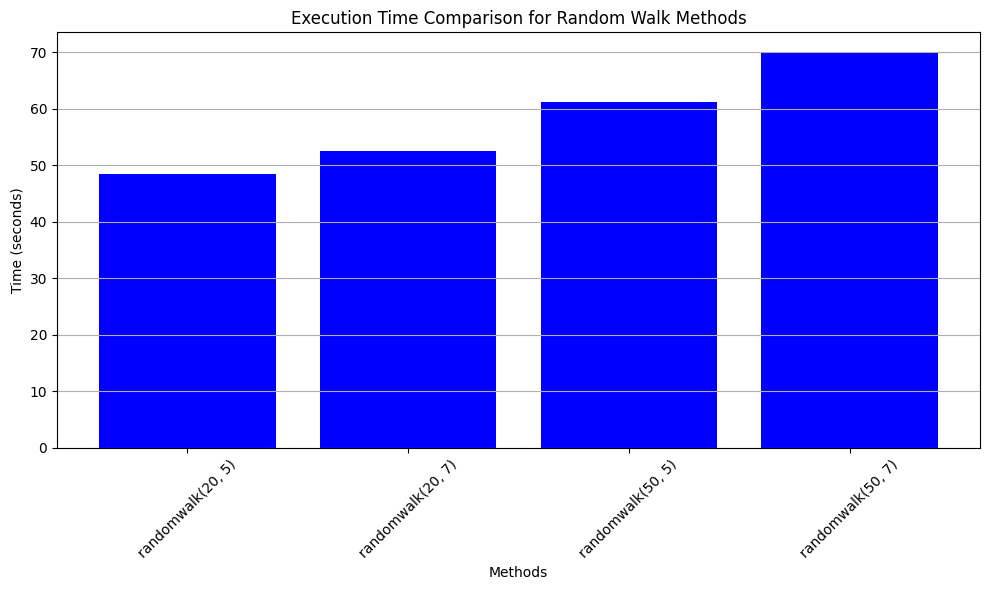

In [168]:
import matplotlib.pyplot as plt

# Times data for randomwalk only
randomwalk_times = [
    ("randomwalk(20, 5)", 48.4),
    ("randomwalk(20, 7)", 52.5),
    ("randomwalk(50, 5)", 61.1),
    ("randomwalk(50, 7)", 70)
]

# Extract labels and values
labels, values = zip(*randomwalk_times)

# Convert values to minutes
values = [v for v in values]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='blue')
plt.xlabel('Methods')
plt.ylabel('Time (seconds)')
plt.title('Execution Time Comparison for Random Walk Methods')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()

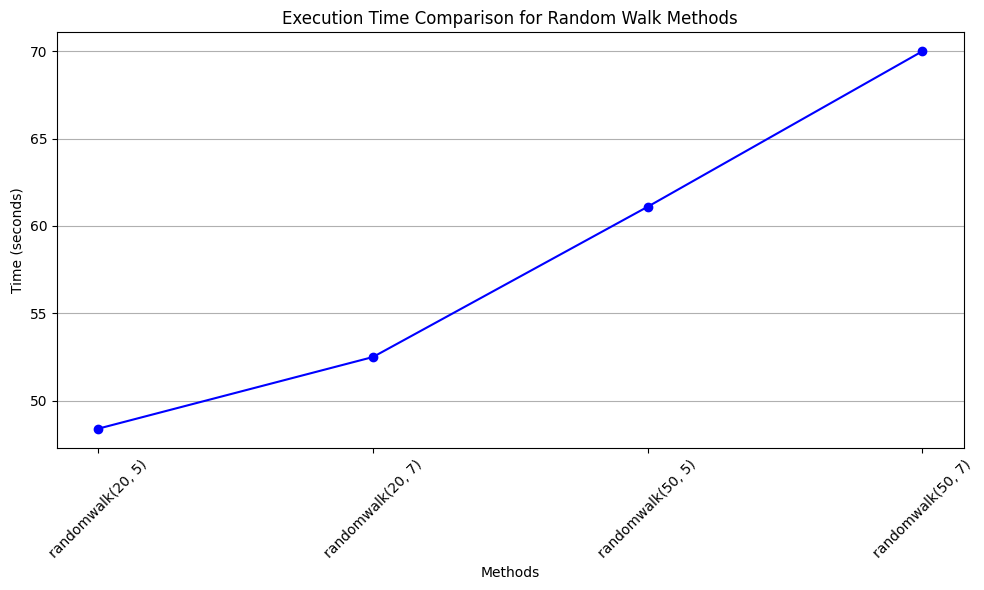

In [155]:
import matplotlib.pyplot as plt

# Times data for randomwalk only
randomwalk_times = [
    ("randomwalk(20, 5)", 48.4),
    ("randomwalk(20, 7)", 52.5),
    ("randomwalk(50, 5)", 61.1),
    ("randomwalk(50, 7)", 70)
]

# Extract labels and values
labels, values = zip(*randomwalk_times)

# Convert values to minutes
values = [v for v in values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(labels, values, marker='o', color='blue')
plt.xlabel('Methods')
plt.ylabel('Time (seconds)')
plt.title('Execution Time Comparison for Random Walk Methods')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

plt.show()


## Second level embedding

In [254]:
train_set = pd.read_csv("train_set.csv")

In [257]:
from pycleora import SparseMatrix
import numpy as np
import pandas as pd
import random

def train_cleora2(input, embedding_size=1024, num_walks=4):
    input['user_id'] = 'u' + input['user_id'].astype(str)
    input['app_id'] = 'a' + input['app_id'].astype(str)

    input.rename(columns={"user_id": "source", "app_id": "target"}, inplace=True)

    user_games_positive = input.groupby('source')['target'].apply(list).values

    for i in range(len(user_games_positive)):
        for j in range(len(user_games_positive[i])):
            user_games_positive[i][j] = str(user_games_positive[i][j])

    cleora_input = map(lambda x: ' '.join(map(str, x)), user_games_positive)
    for i in range(len(user_games_positive)):
        for j in range(len(user_games_positive[i])):
            user_games_positive[i][j] = str(user_games_positive[i][j])

    mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::target')

    embeddings = mat.initialize_deterministically(embedding_size)


    for i in range(num_walks):
        embeddings = mat.left_markov_propagate(embeddings)
        embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

    # game_embedding = dict()

    # for entity, embedding in zip(mat.entity_ids, embeddings):
    #     game_embedding[entity] = embedding

    return (mat.entity_ids, embeddings)


In [258]:
cleora2 = train_cleora2(train_set, embedding_size=4096, num_walks=4)

In [ ]:
import heapq

games_similarity = []
k = 20

names, embeddings = cleora2

for i in range(len(embeddings)):

    temp = []
    if i % 100 == 0:
        print(f"{i/len(embeddings)}, {i} / {len(embeddings)}")
    for j in range(0, i):
        dot = np.dot(embeddings[i], embeddings[j])
        dot = -1 * dot

        # if dot > -0.9:
        #     print(dot)

        if len(temp) < k:
            heapq.heappush(temp, (dot, j))
        else:
            heapq.heappushpop(temp, (dot, j))

    for j in range(i + 1, len(embeddings)):
        dot = np.dot(embeddings[i], embeddings[j])
        dot = -1 * dot

        # if dot > -0.9:
        #     print(dot)

        if len(temp) < k:
            heapq.heappush(temp, (dot, j))
        else:
            heapq.heappushpop(temp, (dot, j))
    games_similarity.append((names[i], temp))


0.0, 0 / 35302
0.0028327006968443713, 100 / 35302
0.005665401393688743, 200 / 35302
0.008498102090533114, 300 / 35302
0.011330802787377485, 400 / 35302
0.014163503484221858, 500 / 35302
0.01699620418106623, 600 / 35302
0.0198289048779106, 700 / 35302
0.02266160557475497, 800 / 35302
0.02549430627159934, 900 / 35302
0.028327006968443716, 1000 / 35302
0.031159707665288087, 1100 / 35302
0.03399240836213246, 1200 / 35302
0.036825109058976825, 1300 / 35302
0.0396578097558212, 1400 / 35302
0.042490510452665574, 1500 / 35302
0.04532321114950994, 1600 / 35302
0.048155911846354316, 1700 / 35302
0.05098861254319868, 1800 / 35302
0.05382131324004306, 1900 / 35302
0.05665401393688743, 2000 / 35302
0.0594867146337318, 2100 / 35302
0.062319415330576174, 2200 / 35302
0.06515211602742055, 2300 / 35302
0.06798481672426492, 2400 / 35302
0.07081751742110928, 2500 / 35302
0.07365021811795365, 2600 / 35302
0.07648291881479803, 2700 / 35302
0.0793156195116424, 2800 / 35302
0.08214832020848677, 2900 / 35302


In [261]:
with open("games_similarity2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(games_similarity)

In [307]:
games_similarity = pd.read_csv("games_similarity2.csv", header=None)

In [ ]:
# games_ids = mat.entity_ids

#empirically chosen based on the average similarity between embeddings
similarity_treshold = -0.5

games_edges = []
print(len(games_similarity))
for i in range(len(games_similarity)):
    games_similarity[i]
for i in range(len(names)):
    for j in range(len(games_similarity[1][i])):
        print(games_similarity[1][i][0])
        if float(games_similarity[i][1][j][0]) < similarity_treshold:
            games_edges.append((names[i], names[games_similarity[i][1][j][1]]))
    # for j in range(i + 1, len(names)):
    #     if games_similarity[i][j] > similarity_treshold:
    #         games_edges.append((games_ids[i], games_ids[j]))

35302


C:\Users\MAX\AppData\Local\Temp\ipykernel_31508\32988594.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  games_similarity[1][i] = eval(games_similarity[1][i])


a1749380 xd


IndexError: string index out of range

In [263]:
games_edges_df = pd.DataFrame(games_edges, columns=["source", "target"])
games_edges_df.to_csv("games_edges2.csv", index=False)

In [264]:
# games_edges_df = pd.DataFrame(games_edges, columns=["source", "target"])

user_games_df = train_set[["source", "target"]]

# games_edges_df[type] = 'g-g'
# user_games_df[type] = 'u-g'

combined_edges = pd.concat([games_edges_df, user_games_df], ignore_index=True)

combined_edges.to_csv("combined_edges2.csv", index=False)

In [265]:
def train_cleora3(input, embedding_size=1024, num_walks=4):
    user_games_positive = input.groupby('target')['source'].apply(list).values

    for i in range(len(user_games_positive)):
        for j in range(len(user_games_positive[i])):
            user_games_positive[i][j] = str(user_games_positive[i][j])

    cleora_input = map(lambda x: ' '.join(map(str, x)), user_games_positive)

    mat = SparseMatrix.from_iterator(cleora_input, columns='complex::reflexive::source')

    embeddings = mat.initialize_deterministically(embedding_size)


    for i in range(num_walks):
        embeddings = mat.left_markov_propagate(embeddings)
        embeddings /= np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)

    game_embedding = dict()

    for entity, embedding in zip(mat.entity_ids, embeddings):
        game_embedding[entity] = embedding

    return game_embedding


In [266]:
cleora3 = train_cleora3(combined_edges, embedding_size=4096, num_walks=4)

Cleora3 to jest słownik który jako klucze ma gry i userów, a wratosci to embedingi

Trzeba podzielić słownik na słownik gier i słownik użytkownikow

Potem dla kazdego uzytkownika trzeba policzyc najlepsze(najbliższe) embedingi gier

In [267]:
test_set3 = test_set.copy()

In [268]:
test_set3.head()

app_id   user_id
4   1196590   5935019
10   239030   5755947
15  1426210   9381640
17   275850   3205006
21   534380  11343808

In [269]:
test_set3['user_id'] = 'u' + test_set3['user_id'].astype(str)
test_set3['app_id'] = 'a' + test_set3['app_id'].astype(str)

In [270]:
test_set3.head()

app_id    user_id
4   a1196590   u5935019
10   a239030   u5755947
15  a1426210   u9381640
17   a275850   u3205006
21   a534380  u11343808

In [271]:
def append_progress(results, output_file):
    with open(output_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results)

In [272]:
import heapq

users_per_save = 1000
# games_similarity_2 = []
k = 20

output_file = "goat_cleaora2.csv"

user_embeddings_42 = {}
games_embeddings_69 = {}

num_of_batches = 0

for key, item in cleora3.items():
    # print(key[0])
    if key[0] == 'u':
        # print(key)
        user_embeddings_42[key] = item
    else:
        games_embeddings_69[key] = item

max_batches = len(user_embeddings_42)//users_per_save + 1

user_to_games = defaultdict(list)

counter = 0

batch_results = [("user_id", "app_counts")]

for key, user_embeding in user_embeddings_42.items():
    temp = []
    counter += 1
    # if counter % 100 == 0:
    #     print(f"{counter/len(user_embeddings_42)}, {counter} / {len(user_embeddings_42)}")
    # min_similarity = 2

    for key2, game_embedding in games_embeddings_69.items():
        dot = np.dot(user_embeding, game_embedding)
        dot = -1 * dot
        # n1 = np.linalg.norm(user_embeding)
        # n2 = np.linalg.norm(game_embedding)
        # res = dot / (n1 * n2)

        # if res < min_similarity:
        #     min_similarity = res

        if len(temp) < k:
            heapq.heappush(temp, (key2, res))
        else:
            heapq.heappushpop(temp, (key2, res))


    batch_results.append((key, temp))  # JSON-encoded app counts


    if (counter >= users_per_save):
        num_of_batches += 1
        counter = 0
        print(f"Progress save {num_of_batches} batch of {max_batches}")
        append_progress(batch_results, output_file)
        batch_results = []


if batch_results:
    append_progress(batch_results, output_file)
    print("FINAL batch appended. File ready")
    # games_similarity_2.append((names[i], temp))

Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

-----

Test2

In [273]:
# games_ids = mat.entity_ids


games_similarity = pd.read_csv("games_similarity.csv")

#empirically chosen based on the average similarity between embeddings
similarity_treshold = -0.9

games_edges = []

for i in range(len(names)):
    for j in range(len(games_similarity[i][1])):
        if games_similarity[i][1][j][0] < similarity_treshold:
            games_edges.append((names[i], names[games_similarity[i][1][j][1]]))
    # for j in range(i + 1, len(names)):
    #     if games_similarity[i][j] > similarity_treshold:
    #         games_edges.append((games_ids[i], games_ids[j]))

KeyError: 0

In [ ]:
games_edges_df = pd.DataFrame(games_edges, columns=["source", "target"])
games_edges_df.to_csv("games_edges3.csv", index=False)

In [ ]:
# games_edges_df = pd.DataFrame(games_edges, columns=["source", "target"])

user_games_df = train_set[["source", "target"]]

# games_edges_df[type] = 'g-g'
# user_games_df[type] = 'u-g'

combined_edges = pd.concat([games_edges_df, user_games_df], ignore_index=True)

combined_edges.to_csv("combined_edges3.csv", index=False)

In [ ]:
cleora4 = train_cleora3(combined_edges, embedding_size=4096, num_walks=4)

In [ ]:
test_set4 = test_set.copy()

In [ ]:
test_set4.head()

In [ ]:
test_set4['user_id'] = 'u' + test_set4['user_id'].astype(str)
test_set4['app_id'] = 'a' + test_set4['app_id'].astype(str)

In [310]:
# test_set4.head()
print(names[22611])

a1145270


In [ ]:
import heapq

users_per_save = 1000
# games_similarity_2 = []
k = 20

output_file = "goat_cleaora3.csv"

user_embeddings_42 = {}
games_embeddings_69 = {}

num_of_batches = 0

for key, item in cleora4.items():
    # print(key[0])
    if key[0] == 'u':
        # print(key)
        user_embeddings_42[key] = item
    else:
        games_embeddings_69[key] = item

max_batches = len(user_embeddings_42)//users_per_save + 1

user_to_games = defaultdict(list)

counter = 0

batch_results = [("user_id", "app_counts")]

for key, user_embeding in user_embeddings_42.items():
    temp = []
    counter += 1
    # if counter % 100 == 0:
    #     print(f"{counter/len(user_embeddings_42)}, {counter} / {len(user_embeddings_42)}")
    # min_similarity = 2

    for key2, game_embedding in games_embeddings_69.items():
        dot = np.dot(user_embeding, game_embedding)
        dot = -1 * dot
        # n1 = np.linalg.norm(user_embeding)
        # n2 = np.linalg.norm(game_embedding)
        # res = dot / (n1 * n2)

        # if res < min_similarity:
        #     min_similarity = res

        if len(temp) < k:
            heapq.heappush(temp, (key2, res))
        else:
            heapq.heappushpop(temp, (key2, res))


    batch_results.append((key, temp))  # JSON-encoded app counts


    if (counter >= users_per_save):
        num_of_batches += 1
        counter = 0
        print(f"Progress save {num_of_batches} batch of {max_batches}")
        append_progress(batch_results, output_file)
        batch_results = []


if batch_results:
    append_progress(batch_results, output_file)
    print("FINAL batch appended. File ready")
    # games_similarity_2.append((names[i], temp))

----

In [1]:
import pandas as pd
cleor = pd.read_csv("cleora_4096_5_random_50_5.csv")

In [3]:
def get_game_title(app_id, games_df):
    game = games_df.loc[games_df['app_id'] == app_id]
    if not game.empty:
        return game.iloc[0]['title']
    else:
        return None

In [10]:
def find_recommended_games(user_id, positive_df):

    positive_games = positive_df[positive_df['user_id'] == user_id]['app_id'].tolist()

    positive_games = [get_game_title(int(game), games) for game in positive_games]

    return {
        'Opinions': positive_games,
    }

In [5]:
games = pd.read_csv("games.csv")
opinions = pd.read_csv("positive_shrank2.csv")

In [ ]:
def find_recomendation(user_id, model):
    recomendations = model.loc[model["user_id"] == user_id, "app_counts"]
    if recomendations.empty:
        return None
    recomendations = list(recomendations.values[0].items())
    recomendations.sort(key=lambda x: x[1], reverse=True)
    return [get_game_title(int(recomendation[0]), games) for recomendation in recomendations]

In [11]:
find_recommended_games(6209537, opinions)

{'Opinions': ['Grand Theft Auto V',
  'Hunt: Showdown',
  'Wallpaper Engine',
  'Hearts of Iron IV',
  'PlanetSide 2',
  'Undertale',
  'Metro Exodus',
  'Total War: ATTILA',
  'Outlast',
  'Rising Storm 2: Vietnam',
  'Far Cry® 5',
  'Among Us',
  'Titanfall® 2',
  "Assassin's Creed® Odyssey",
  'Rise of the Tomb Raider™',
  'Halo: The Master Chief Collection',
  'Sniper Elite 4',
  'Besiege',
  'The Binding of Isaac',
  'AdVenture Capitalist',
  'Double Action: Boogaloo',
  'Dirty Bomb®',
  'Bit Blaster XL',
  'Emily is Away',
  'Robocraft',
  'Mitos.is: The Game',
  'A Story About My Uncle',
  'Clicker Heroes',
  'Verdun']}

In [21]:
release_embedding_4096_4 = train_cleora(positive_shrank2, embedding_size=4096, num_walks=4)

release_embedding_4096_5 = train_cleora(positive_shrank2, embedding_size=4096, num_walks=5)

In [25]:
random_walk_cleaora("positive_shrank2.csv", 50, 5, release_embedding_4096_4, output_file="release_4.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [26]:
random_walk_cleaora("positive_shrank2.csv", 50, 5, release_embedding_4096_5, output_file="release_5.csv", users_per_save=1000)

C:\Users\MAX\AppData\Local\Temp\ipykernel_35256\651570365.py:34: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


Progress save 1 batch of 96
Progress save 2 batch of 96
Progress save 3 batch of 96
Progress save 4 batch of 96
Progress save 5 batch of 96
Progress save 6 batch of 96
Progress save 7 batch of 96
Progress save 8 batch of 96
Progress save 9 batch of 96
Progress save 10 batch of 96
Progress save 11 batch of 96
Progress save 12 batch of 96
Progress save 13 batch of 96
Progress save 14 batch of 96
Progress save 15 batch of 96
Progress save 16 batch of 96
Progress save 17 batch of 96
Progress save 18 batch of 96
Progress save 19 batch of 96
Progress save 20 batch of 96
Progress save 21 batch of 96
Progress save 22 batch of 96
Progress save 23 batch of 96
Progress save 24 batch of 96
Progress save 25 batch of 96
Progress save 26 batch of 96
Progress save 27 batch of 96
Progress save 28 batch of 96
Progress save 29 batch of 96
Progress save 30 batch of 96
Progress save 31 batch of 96
Progress save 32 batch of 96
Progress save 33 batch of 96
Progress save 34 batch of 96
Progress save 35 batch 

In [27]:
release_5 = pd.read_csv("release_5.csv")
release_4 = pd.read_csv("release_4.csv")

In [64]:
def make_recomendations(user_id, model, how_many=20):
    recomendations = model.loc[model["user_id"] == user_id, "app_counts"]
    if recomendations.empty:
        return None
    # print(recomendations)
    recomendations = eval(recomendations.values[0])
    # print(recomendations)
    recomendations = list(recomendations.items())
    recomendations.sort(key=lambda x: x[1], reverse=True)
    recomendations = recomendations[:how_many]
    return [(get_game_title(int(recomendation[0]), games), recomendation[1]) for recomendation in recomendations],

In [69]:
find_recommended_games(2689434, opinions)


{'Opinions': ['Rust',
  'Cyberpunk 2077',
  'PAYDAY 2',
  'Brawlhalla',
  'The Sims™ 4',
  'The Witcher® 3: Wild Hunt',
  'Apex Legends™',
  'Red Dead Redemption 2',
  'Beat Saber',
  "No Man's Sky",
  'House Flipper',
  'Halo: The Master Chief Collection',
  'Sea of Thieves 2023 Edition',
  'Marvel’s Spider-Man Remastered',
  'Danganronpa 2: Goodbye Despair',
  'Ghostwire: Tokyo',
  'Demon Slayer -Kimetsu no Yaiba- The Hinokami Chronicles',
  'STAR WARS Jedi: Fallen Order™',
  'DEVOUR',
  'Persona 4 Golden',
  'Golf With Your Friends',
  'Danganronpa V3: Killing Harmony',
  'Forza Horizon 4',
  'Judgment',
  'Yakuza: Like a Dragon',
  'Yakuza Kiwami 2',
  'Mortal Kombat X',
  'Yakuza Kiwami',
  'Town of Salem',
  'Friday the 13th: The Game',
  'Resident Evil 4 (2005)',
  'Thief Simulator',
  'Alien: Isolation',
  'Emily is Away Too',
  'Lost Judgment',
  'Pummel Party',
  'The Quarry',
  'The Forest',
  'Left 4 Dead 2',
  'Paladins®',
  'Resident Evil 6']}

In [70]:
make_recomendations(2689434, release_5, 10)

([('Detroit: Become Human', 0.9999997615814209),
  ('Dead Island Definitive Edition', 0.9999997615814209),
  ('Scrap Mechanic', 0.9999997019767761),
  ('Wallpaper Engine', 0.9999997019767761),
  ('Assassin’s Creed® IV Black Flag™', 0.9999996423721313),
  ('I Am Bread', 0.9999996423721313),
  ('PAC-MAN™ CHAMPIONSHIP EDITION 2', 0.9999996423721313),
  ('Bloons TD 6', 0.9999996423721313),
  ('Rise of the Tomb Raider™', 0.9999995827674866),
  ('Sekiro™: Shadows Die Twice - GOTY Edition', 0.9999995827674866)],)